install libraries

In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

importing libraries

In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

defining some parameters

In [ ]:
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

loading the data

In [ ]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

mnist_train, mnist_test

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11121882.85it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1712213.69it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3309955.91it/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7315871.26it/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: /tmp/data/mnist
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
                Normalize(mean=(0,), std=(1,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /tmp/data/mnist
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
                Normalize(mean=(0,), std=(1,))
            ))

defining the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize membrane potential
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x) # linear output of first layer.
            spk1, mem1 = self.lif1(cur1, mem1) # spkies and mem potential of 1st layer.
            cur2 = self.fc2(spk1) # linear output of second layer.
            spk2, mem2 = self.lif2(cur2, mem2) # spikes and potential
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)



create the model

In [ ]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train the model

In [ ]:
def print_batch_accuracy(data, targets):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")



def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets)
    print("\n")




num_epochs = 2
loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1))
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        if counter % 50 == 0:
            train_printer()
        counter += 1
        iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 58.80
Train set accuracy for a single minibatch: 46.88%


Epoch 0, Iteration 50
Train Set Loss: 16.11
Train set accuracy for a single minibatch: 83.59%


Epoch 0, Iteration 100
Train Set Loss: 13.74
Train set accuracy for a single minibatch: 82.03%


Epoch 0, Iteration 150
Train Set Loss: 7.98
Train set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 200
Train Set Loss: 7.55
Train set accuracy for a single minibatch: 94.53%


Epoch 0, Iteration 250
Train Set Loss: 8.61
Train set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 300
Train Set Loss: 7.56
Train set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 350
Train Set Loss: 9.03
Train set accuracy for a single minibatch: 89.84%


Epoch 0, Iteration 400
Train Set Loss: 4.47
Train set accuracy for a single minibatch: 94.53%


Epoch 0, Iteration 450
Train Set Loss: 5.27
Train set accuracy for a single minibatch: 90.62%


Epoch 1, Iteration 32
Train Set Loss: 3.

view losses

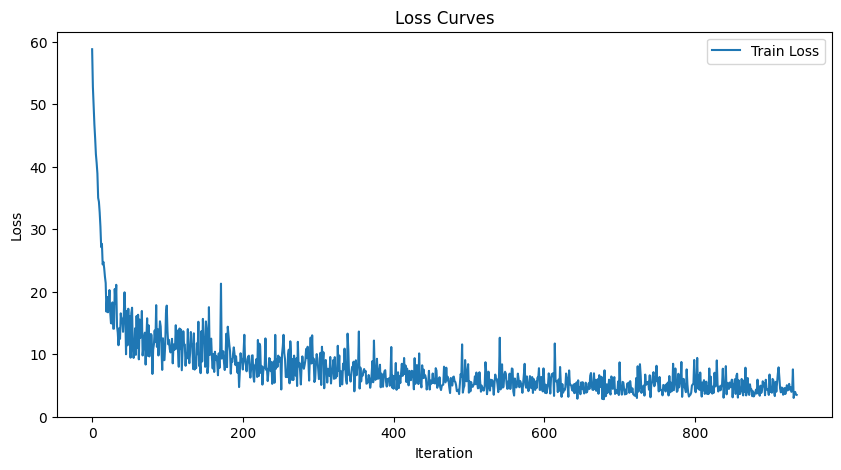

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

testing

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:


    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()


print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")


Total correctly classified test set images: 9479/10000
Test Set Accuracy: 94.79%
